# Augmentations

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import sys
sys.path.insert(0, "../src")

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import albumentations as A

from sklearn import metrics
from sklearn import model_selection

import torch
import torch.nn as nn
import torch.nn.functional as F

import config
import dataset
import engine
import models

In [53]:
df = pd.read_csv(config.TRAIN_CSV)

In [54]:
images = df[config.PIXEL_COLS].values.reshape(-1, 28, 28)

In [55]:
mean = np.mean(images / 255.0)
std = np.std(images / 255.0)
mean, std

(0.14296817848233043, 0.2537516572364304)

In [67]:
augs = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.9),
        A.OneOf(
            [
                A.ElasticTransform(
                    alpha = 120,
                    sigma = 120 * 0.05,
                    alpha_affine = 120 * 0.03
                ),
                A.GridDistortion(),
                A.OpticalDistortion(distort_limit = 2, shift_limit = 0.5),
            ],
            p = 0.5
        ),
        A.OneOf(
            [
                A.RandomContrast(),
                A.RandomGamma(),
                A.RandomBrightness(),
            ],
            p = 0.5
        ),
        A.CoarseDropout(max_holes=4, max_height=4, max_width=4, p=0.25),
        A.Normalize(config.MEAN, config.STD, max_pixel_value=255.0, always_apply=True),
    ]
)

In [68]:
idx = 5
image = images[idx]
image = image.astype(np.uint8)

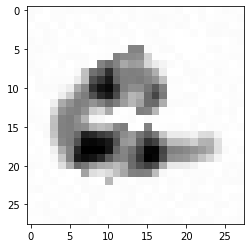

In [69]:
plt.imshow(image, cmap=plt.cm.binary);

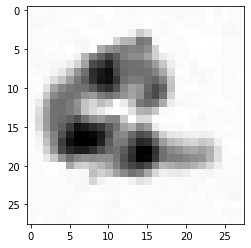

In [70]:
augmented = augs(image=image)
aug_image = augmented["image"]
plt.imshow(aug_image, cmap=plt.cm.binary);

## Train

In [76]:
device = torch.device(config.DEVICE)

In [77]:
df_train, df_valid = model_selection.train_test_split(df, test_size=0.1, stratify=df.digit)

train_dataset = dataset.EMNISTDataset(df_train, augs=augs)
valid_dataset = dataset.EMNISTDataset(df_valid)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.TRAIN_BATCH_SIZE, shuffle=True)    
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.TEST_BATCH_SIZE)

In [78]:
model = models.SpinalVGG()
model.to(device)

optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', verbose=True, patience=10, factor=0.5
)

for epoch in range(config.EPOCHS):
    engine.train(train_loader, model, optimizer, device)
    predictions, targets = engine.evaluate(valid_loader, model, device)

    predictions = np.array(predictions)
    predictions = np.argmax(predictions, axis=1)
    accuracy = metrics.accuracy_score(targets, predictions)
    
    scheduler.step(accuracy)
    
    print(f"Epoch: {epoch}, Accuracy={accuracy}")

Epoch: 0, Accuracy=0.15609756097560976
Epoch: 1, Accuracy=0.33658536585365856
Epoch: 2, Accuracy=0.3853658536585366
Epoch: 3, Accuracy=0.5317073170731708
Epoch: 4, Accuracy=0.6097560975609756
Epoch: 5, Accuracy=0.6341463414634146
Epoch: 6, Accuracy=0.5560975609756098
Epoch: 7, Accuracy=0.6048780487804878
Epoch: 8, Accuracy=0.5707317073170731
Epoch: 9, Accuracy=0.7219512195121951
Epoch: 10, Accuracy=0.7317073170731707
Epoch: 11, Accuracy=0.751219512195122
Epoch: 12, Accuracy=0.7170731707317073
Epoch: 13, Accuracy=0.775609756097561
Epoch: 14, Accuracy=0.7853658536585366
Epoch: 15, Accuracy=0.8341463414634146
Epoch: 16, Accuracy=0.848780487804878
Epoch: 17, Accuracy=0.7951219512195122
Epoch: 18, Accuracy=0.775609756097561
Epoch: 19, Accuracy=0.8048780487804879
Epoch: 20, Accuracy=0.8439024390243902
Epoch: 21, Accuracy=0.775609756097561
Epoch: 22, Accuracy=0.8097560975609757
Epoch: 23, Accuracy=0.8292682926829268
Epoch: 24, Accuracy=0.7658536585365854
Epoch: 25, Accuracy=0.824390243902439


In [29]:
torch.save(model.state_dict(), "../models/augs.pt")

## Inference

In [31]:
# model = models.Model()
model = models.SpinalVGG()
model.load_state_dict(torch.load("../models/augs.pt"))
model.to(device)

<All keys matched successfully>

In [19]:
df_test = pd.read_csv(config.TEST_CSV)
test_dataset = dataset.EMNISTTestDataset(df_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.TEST_BATCH_SIZE)

In [49]:
predictions = engine.infer(test_loader, model, device)
predictions = np.array(predictions)
predictions = np.argmax(predictions, axis=1)

In [50]:
submission = pd.DataFrame({"id": df_test.id, "digit": predictions})
submission.to_csv("../output/augs.csv", index=False)
submission.head()

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3


### TTA

In [ ]:
predictions = engine.inferTTA(df_test, model, device, augs)
predictions = np.argmax(predictions, axis=1)

In [ ]:
submission = pd.DataFrame({"id": df_test.id, "digit": predictions})
submission.to_csv("../output/augs_tta.csv", index=False)
submission.head()